<a href="https://colab.research.google.com/github/stephenbrutch/PINNS-and-IPINNS/blob/main/pinn_pytorch2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

https://youtu.be/G_hIppUWcsc

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

# Initial setup

## define exact solution

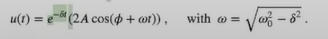

In [2]:
def exact_solution(d,w0,t):
  '''
  Defines the analytical soluion to the underdamped harmonic oscillator problem above
  '''
  assert d<w0
  w=np.sqrt(w0**2-d**2)
  phi=np.arctan(-d/w)
  A=1/(2*np.cos(phi))
  cos=torch.cos(phi+w*t)
  exp=torch.exp(-d*t)
  u=exp*2*A*cos

  return u

## define simple FFNN

In [3]:
class FCN(nn.Module):
  '''
  Defines a standrd full connected network in Pytorch
  '''

  def __init__(self,N_INPUT,N_OUTPUT,N_HIDDEN,N_LAYERS):
    super().__init__()
    activation=nn.Tanh
    self.fcs=nn.Sequential(*[
        nn.Linear(N_INPUT,N_HIDDEN),
        activation()])
    self.fch=nn.Sequential(*[
        nn.Sequential(*[
        nn.Linear(N_HIDDEN,N_HIDDEN),
                        activation()]) for _ in range(N_LAYERS-1)])
    self.fce=nn.Linear(N_HIDDEN,N_OUTPUT)
  def forward(self,x):
    x-self.fcs(x)
    x=self.fch(x)
    x=self.fce(x)
    return x

## define the boundary points for the boundary loss

In [4]:
t_boundary=torch.tensor(0.).view(-1,1).requires_grad_(True)

## define the training points over the entire domain

In [5]:
t_physics=torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

## train the PINN

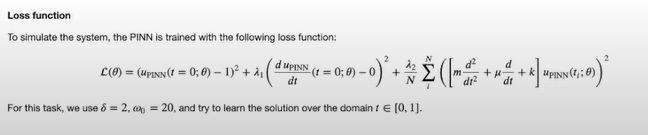

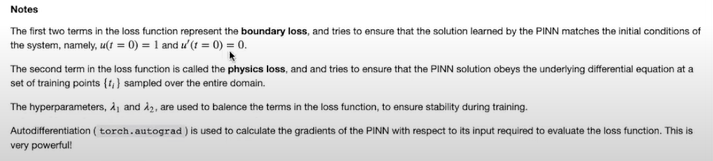

# attempt 2

## pinn

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import math
#import torch.nn.modules.constraints as constraints
import torch.optim as optim

In [7]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x



In [8]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True) #(0,1,30)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1) #(0,1,300)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)

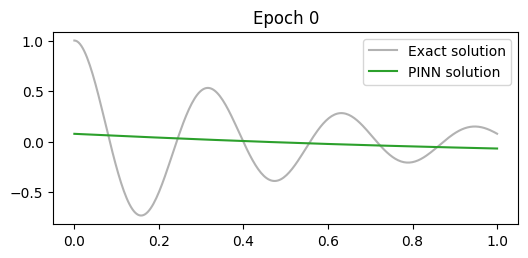

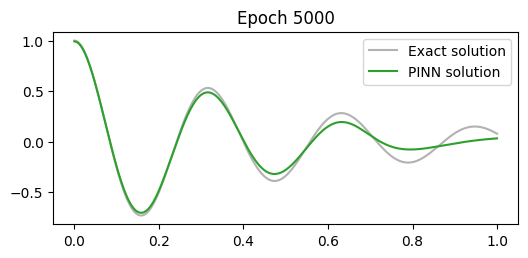

In [9]:
for i in range(5001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        #plt.scatter(t_physics.detach()[:,0],
                    #torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        #plt.scatter(t_boundary.detach()[:,0],
                    #torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Epoch {i}")
        plt.legend()
        plt.show()

## ipinn

True value of mu: 4


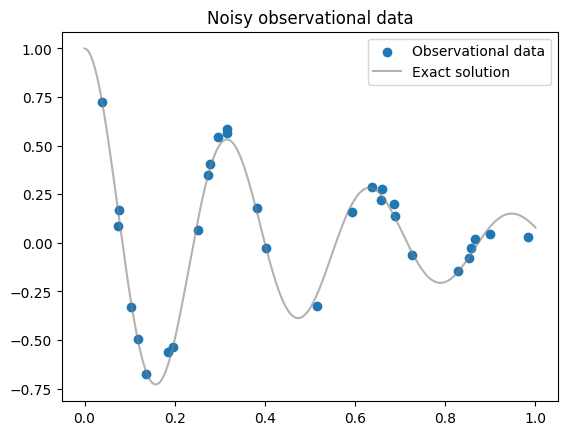

In [10]:
# first, create some noisy observational data
torch.manual_seed(123)
d, w0 = 2, 20
print(f"True value of mu: {2*d}")
t_obs =  (1 * torch.rand(30).view(-1,1)).reshape(30,1)
u_obs = exact_solution(d, w0, t_obs) + 0.04*torch.randn_like(t_obs)

plt.figure()
plt.title("Noisy observational data")
plt.scatter(t_obs[:,0], u_obs[:,0],label="Observational data")
t_test, u_exact = torch.linspace(0,1,300).view(-1,1), exact_solution(d, w0, t_test)
plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
plt.legend()
plt.show()

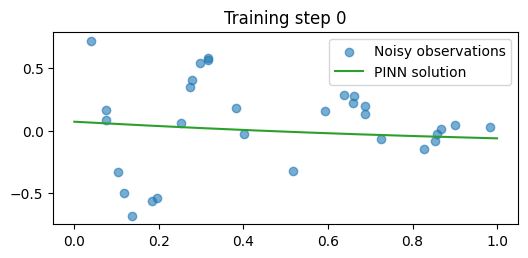

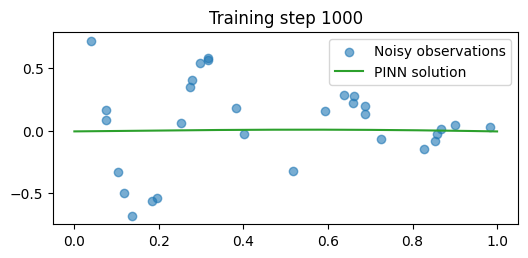

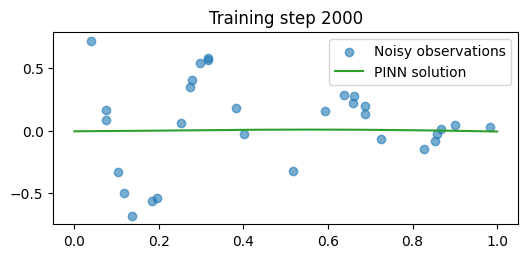

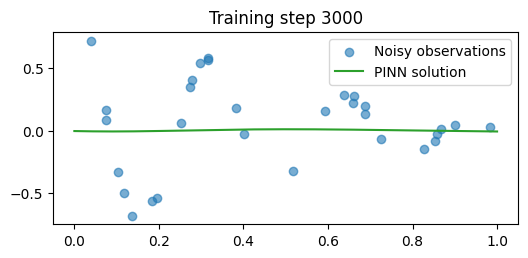

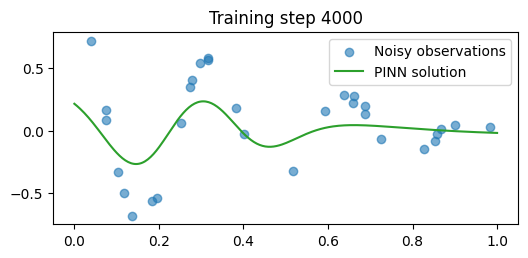

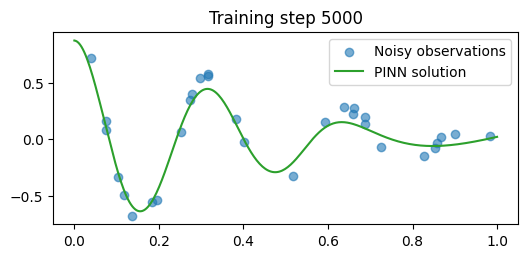

In [15]:
torch.manual_seed(123)

# define a neural network to train
pinn = FCN(1,1,32,3)

# define training points over the entire domain, for the physics loss
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
_, k = 2*d, w0**2

# treat mu as a learnable parameter
mu = torch.nn.Parameter(torch.zeros(1, requires_grad=True))
mu_init = mu.detach()
mus = []

# add mu to the optimiser
optimiser = torch.optim.Adam(list(pinn.parameters())+[mu],lr=1e-3)

loss_history=[]

for i in range(5001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1 = 1e4 #uncomment for good results
    #lambda1=1e2

    # compute physics loss
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss1 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    #print(f"mu = {mu}")

    # compute data loss
    # TODO: write code here
    u = pinn(t_obs)
    loss2 = torch.mean((u - u_obs)**2)


    # backpropagate joint loss, take optimiser step
    loss = loss1 + lambda1*loss2
    loss_history.append(loss.item())
    loss.backward()

    # Uncomment the line below if you want to see how the model learns if the mu variable is bounded between 3 and 5.
    #mu.data = torch.clamp(mu.data, 3, 5)

    optimiser.step()

    # record mu value
    # TODO: write code here
    mus.append(mu.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_obs[:,0], u_obs[:,0], label="Noisy observations", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()



In [16]:
torch.tensor(mus).shape, mu_init.shape

(torch.Size([5001]), torch.Size([1]))

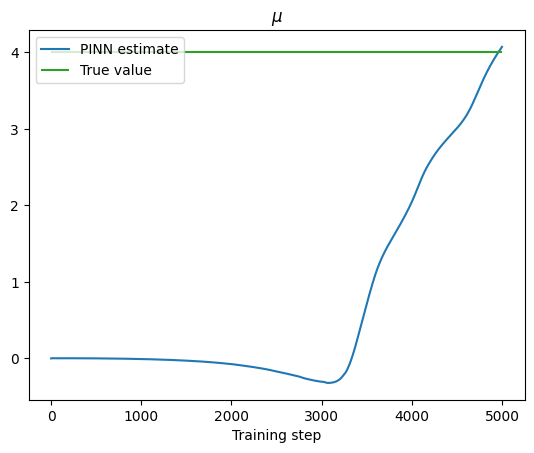

In [17]:
plt.figure()
plt.title("$\mu$")
#mus = torch.cat((mu_init,torch.tensor(mus)),dim=0)
plt.plot(torch.tensor(mus), label="PINN estimate")
plt.hlines(2*d, 0, len(mus), label="True value", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()